In [1]:
import torch
from torch.optim.adamw import adamw
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from transformers import AutoModel
import pandas as pd

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA toolkit version:", torch.version.cuda)
print("Device name:", torch.cuda.get_device_name(0))

F:\UOJE\Research\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Torch version: 2.7.1+cu118
CUDA available: True
CUDA toolkit version: 11.8
Device name: NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
from transformers import pipeline

pipe = pipeline("fill-mask", model="NLPC-UOM/SinBERT-large")
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("NLPC-UOM/SinBERT-large")
model = AutoModelForMaskedLM.from_pretrained("NLPC-UOM/SinBERT-large")

Device set to use cuda:0


In [3]:
import numpy as np
import torch

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [8]:
from torch.optim import AdamW
df = pd.read_csv('./processed/processed_dataset.csv')

# After loading df and before defining criterion
labels = df['label'].values
class_sample_count = np.array([np.sum(labels == t) for t in np.unique(labels)])
weight = 1. / class_sample_count

#converts numpy array of weights to torch tensor and move it to the same device as the model
class_weights = torch.tensor(weight, dtype=torch.float).to(device)

# Use in loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer= AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

In [6]:
class_sample_count

array([614, 540, 502, 500, 519, 353])

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel

## Creating the DataSet Class


the class wich represent the data.the dataloder will use this class to load the data one by one or in batches.it relies on 2 methods.

- `__len__`    - returns the length of the dataset
- `__getitem__` - returns the item at the given index
Also it has the constructor which takes the dataframe, tokenizer and max_length as input parameters.
- `__init__`- constructor to initialize the dataset with a dataframe, tokenizer, and maximum sequence length.
    - `self.text`,`self.label` - store the raw sinhala texts and labels from the dataframe.
    - `self.tokenizer` - stores the tokenizer object.
    - `self.max_length` - stores the maximum length of the input sequence.all the sentences will be padded or truncated to this length.

In [20]:
from torch.utils.data import Dataset
from transformers import AutoTokenizer
import torch

class SinhalaEmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

## Dataloader

In [22]:
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split


df_train,df_test=train_test_split(df,test_size=0.2,random_state=42,stratify=df['label'])#stratify is used to maintain the class distribution in the train and test sets(emotion percentages are same in both sets).

#Dataset and Dataloader
BATCH_SIZE = 16
# Instantiate the custom dataset for each split
train_dataset = SinhalaEmotionDataset(
    texts=df_train['text'].tolist(),
    labels=df_train['label'].tolist(),
    tokenizer=tokenizer
)

test_dataset = SinhalaEmotionDataset(
    texts=df_test['text'].tolist(),
    labels=df_test['label'].tolist(),
    tokenizer=tokenizer
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
# Set up the DataLoader for each split
train_data_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE
)

print("Data Loaders for training, validation, and testing are ready.")

Data Loaders for training, validation, and testing are ready.


## Building the Model Architecture


every pytorch model should inherit from `nn.Module` class. The model should have the following methods.
- `__init__` - constructor to initialize the model with a pre-trained BERT model and a CNN layer.
    - `self.bert` - stores the pre-trained BERT model.
    - `self.cnn` - stores the CNN layer.
    - `self.relu` - stores the ReLU activation function.
    - `self.pool` - stores the adaptive max pooling layer.

In [23]:
import torch.nn as nn
from transformers import RobertaModel

class SinbertCNN(nn.Module):
    def __init__(self, num_labels, embedding_dim=1024, num_filters=100, kernel_sizes=[3, 4, 5], dropout_rate=0.5):
        super(SinbertCNN, self).__init__()

        # 1. Sinbert Encoder (RoBERTa-based)
        # The NLPC-UOM/SinBERT-large model is a RoBERTa-based model
        self.sinbert = RobertaModel.from_pretrained("NLPC-UOM/SinBERT-large")

        # 2. CNN Layers
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim,
                      out_channels=num_filters,
                      kernel_size=k)
            for k in kernel_sizes
        ])

        # 3. Dropout Layer
        self.dropout = nn.Dropout(dropout_rate)

        # 4. Classification Head
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_labels)

    def forward(self, input_ids, attention_mask):
        # Forward pass through Sinbert. RoBERTa does not use token_type_ids.
        outputs = self.sinbert(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state

        # Transpose to fit CNN input
        x = embeddings.permute(0, 2, 1)

        # Apply CNN and Max-Pooling
        conv_outputs = [torch.relu(conv(x)) for conv in self.convs]
        pooled_outputs = [torch.max(conv_output, dim=2)[0] for conv_output in conv_outputs]

        # Concatenate outputs from all CNN layers
        concatenated_output = torch.cat(pooled_outputs, dim=1)

        # Apply dropout
        dropout_output = self.dropout(concatenated_output)

        # Final classification
        logits = self.fc(dropout_output)

        return logits

## Training the Model

## Validation

In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_metrics(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits if hasattr(outputs, 'logits') else outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    return acc, precision, recall, f1

# Usage:
acc, precision, recall, f1 = evaluate_metrics(model, train_loader, device)
print(f'Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')

ValueError: Classification metrics can't handle a mix of multiclass and multiclass-multioutput targets

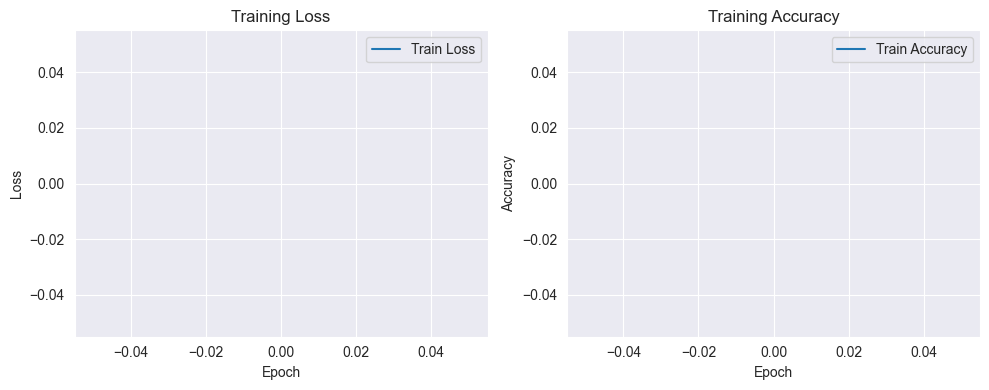

In [19]:
import matplotlib.pyplot as plt

# Example lists to store metrics
train_losses = []
train_accuracies = []

# After each epoch in your training loop, append metrics:
# train_losses.append(epoch_loss)
# train_accuracies.append(epoch_accuracy)

# Plotting
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()